In [1]:
import os

# Data analytics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Feature processing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Data modeling
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import (
    explained_variance_score,
    r2_score,
    mean_squared_error)

# Geospatial packages
import h3
import geopandas as gpd
from shapely import Point, Polygon
from pysal.explore import esda
from libpysal.weights import Queen, lag_spatial
from splot.esda import moran_scatterplot, lisa_cluster

c:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
c:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
c:\Users\Miguel\Documents\Github\

# Modelo de regresón lineal agregado por año y elemento H3

El modelo de este notebook utiliza técnicas convencionales de aprendizaje automático para un regresión lineal.

El tratamiento del componente geoespacial, es decir, los elementos de malla hexagonales de H3, se incorpora al modelo utilizando _One Hot Encoding_ de los elementos de la malla.

Para las primeras iteraciones, se utilizará un modelo sin componente temporal de la forma:

$$y = \beta_0 + \beta_1\cdot\hat T_{t,i} + \beta_2\cdot\hat P_{t,i} + \phi_{[H]}$$

En donde:
* $\hat T_{t,i}$: Temperatura promedio del $i$-ésimo elemento hexagonal al tiempo $t$
* $\hat P_{t,i}$: Precipitación promedio del $i$-ésimo elemento hexagonal al tiempo $t$
* $\phi_{[H]}$: Efecto del elemento hexagonal $H$ como variable indicadora

Dada la estructura de datos, se pueden utilizar los datos del **2014 al 2018** como conjunto de **entrenamiento**, los datos del **2019** como conjunto de **prueba**.

## Carga de datos

In [2]:
# Ruta a archivos de datos
DATA_PATH = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'datos-produccion-maiz',
    'hist-maize-panel-rcp2p6.csv')

H3_CATALOGUE = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'datos-produccion-maiz',
    '01_h3_cells_catalogue.csv')

# Carga de datos
data = pd.read_csv(DATA_PATH)
cat_h3 = pd.read_csv(H3_CATALOGUE)
h3_res = 'hex_3'

# Unir resolución de malla a datos
data = (
    data
    .join(
        other=cat_h3[['id',h3_res]]
        ,on='id'
        ,how='left'
        ,rsuffix='__ignore')
    .drop(columns=['id','lon','lat','mean.precip.2','mean.temp.2','id__ignore'])
    .query("(year >= 2016) & (year <= 2019)")
    .groupby(by=['year', h3_res])
    .mean()
    .reset_index())

data.columns = [col.replace('.','_') for col in data.columns]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32840 entries, 0 to 32839
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         32840 non-null  int64  
 1   hex_3        32840 non-null  object 
 2   mean_precip  32840 non-null  float64
 3   mean_temp    32840 non-null  float64
 4   mean_yield   32840 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.3+ MB


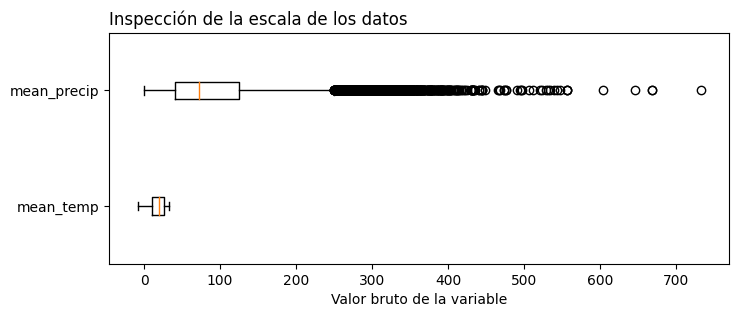

In [3]:
# Variables de visualización
vis_feats = ['mean_temp','mean_precip']

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.boxplot(
    x=data.filter(items=vis_feats),
    vert=False)

# Anotaciones y estilo
ax.set_title('Inspección de la escala de los datos', loc='left')
ax.set_yticks(ticks=[1,2], labels=vis_feats)
ax.set_xlabel('Valor bruto de la variable')

plt.show()

Dada la diferencia en la escala de los datos, se aplicará algún tipo de estandarización a la variables de entrada al modelo

## Partición en Train y Test

In [4]:
# Definición de variable objetivo
target = 'mean_yield'

# Partición de conjuntos de datos
# Estructura de predictores
# 0: h3_res
# 1: mean_precip
# 2: mean_temp

x_train = (
    data
    .query("year <= 2018")
    .drop(columns=['year',target]))
    #.to_numpy())
y_train = (
    data
    .query("year <= 2018")
    .filter(items=[target]))
    #.to_numpy())

x_test = (
    data
    .query("year == 2019")
    .drop(columns=['year',target]))
    #.to_numpy())
y_test = (
    data
    .query("year == 2019")
    .filter(items=[target]))
    #.to_numpy())

print(
    f"""Datasets dimensions:
    x_train: {x_train.shape}
    y_train: {y_train.shape}
    x_test: {x_test.shape}
    y_test: {y_test.shape}""")

Datasets dimensions:
    x_train: (24630, 3)
    y_train: (24630, 1)
    x_test: (8210, 3)
    y_test: (8210, 1)


## Ingeniería de características

Primero se construye la cadena de transformaciones de los datos

In [5]:
# Numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),])

# One Hot Encoder
ohe_encoder = OneHotEncoder(
    drop='first',
    handle_unknown='error',
    sparse_output=False,
    dtype=int)

# Full pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, x_train.select_dtypes(include=[int, float]).columns),
    ('cat', ohe_encoder, x_train.select_dtypes(include=[object]).columns)])

In [6]:
x_train = full_pipeline.fit_transform(x_train).astype(np.float16)
x_test = full_pipeline.fit_transform(x_test).astype(np.float16)

# Inspeccionar dimensiones
x_train.dtype, x_train.shape, x_test.dtype, x_test.shape

(dtype('float16'), (24630, 8211), dtype('float16'), (8210, 8211))

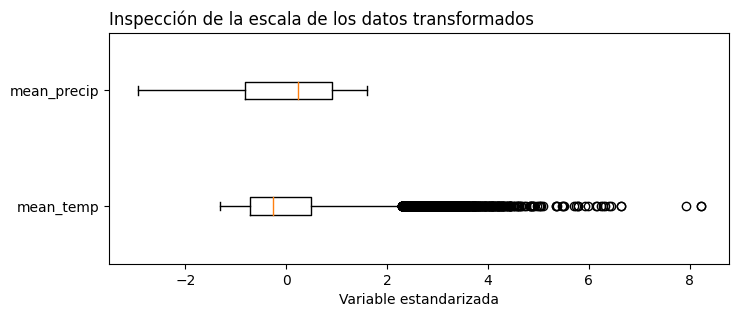

In [7]:
# Variables de visualización
vis_feats = ['mean_temp','mean_precip']

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.boxplot(
    x=x_train[:,0:2],
    vert=False)

# Anotaciones y estilo
ax.set_title('Inspección de la escala de los datos transformados', loc='left')
ax.set_yticks(ticks=[1,2], labels=vis_feats)
ax.set_xlabel('Variable estandarizada')

plt.show()

## Modelo de regresión lineal

Entrenamiento de modelo

Tiempo de procesamiento: [`6min 48s`, `7min 38s`, `7min 34s`, `6min 58s`]

In [8]:
%%time
# Iniciar instancia de modelo
ols = LinearRegression(
    fit_intercept=True,
    n_jobs=-1)

# Entrenamiento
ols.fit(X=x_train, y=y_train)

CPU times: total: 5min 32s
Wall time: 2min 1s


LinearRegression(n_jobs=-1)

Coeficiente de determinación para datos de entrenamiento

$R^2 = 0.9482$

In [10]:
ols.score(X=x_train, y=y_train)

0.948299856438052

Otras métricas de desempeño dentro del conjunto de entramiento

In [11]:
y_pred = ols.predict(X=x_train)

In [12]:
var_score_train = explained_variance_score(y_true=y_train, y_pred=y_pred)
r2_train = r2_score(y_true=y_train, y_pred=y_pred)
rmse_train = mean_squared_error(y_true=y_train, y_pred=y_pred)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_train:.2f} %
    coef. determinación: {r2_train:.6f}
    RMSE: {np.sqrt(rmse_train):.6f}""")

Métricas en train:
    varianza explicada: 94.83 %
    coef. determinación: 0.948300
    RMSE: 0.833880


## Desempeño en conjunto de Prueba

In [13]:
y_pred = ols.predict(X=x_test)

In [14]:
var_score_val = explained_variance_score(y_true=y_test, y_pred=y_pred)
r2_val = r2_score(y_true=y_test, y_pred=y_pred)
rmse_val = mean_squared_error(y_true=y_test, y_pred=y_pred)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_val:.2f} %
    coef. determinación: {r2_val:.6f}
    RMSE: {np.sqrt(rmse_val):.6f}""")

Métricas en train:
    varianza explicada: 87.85 %
    coef. determinación: 0.872557
    RMSE: 1.256832


## Normalidad geoespacial de residuales

### Datos expandidos

In [15]:
out_path = os.path.join(
    '..','data',
    'models_output',
    '01_ols_regression.csv')

In [16]:
residual_test = (
    data
    .query("year == 2019")
    .assign(
        mean_yield_pred = y_pred,
        residuals = lambda df: df.mean_yield_pred - df.mean_yield))

residual_test.to_csv(out_path, index=False)

Carga de datos expandidos leyendo el archivo de salida del modelo

In [17]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)
residual_test.head()

,year,hex_3,mean_precip,mean_temp,mean_yield,mean_yield_pred,residuals
0,2019,830830fffffffff,136.512866,7.503748,5.291118,5.328183,0.037065
1,2019,830833fffffffff,112.218055,7.974006,4.755333,5.408635,0.653302
2,2019,830880fffffffff,55.103881,7.570549,5.866617,4.922041,-0.944576
3,2019,830882fffffffff,44.416754,8.394179,5.053000,4.352239,-0.700761
4,2019,830883fffffffff,65.744323,9.267750,4.921000,5.576919,0.655919


In [18]:
def get_h3_polygon(row:str):
    points = h3.cell_to_boundary(
        h=row
        ,geo_json=True)

    return Polygon(points)

In [19]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)

# Definir columna de geometría
geometry = gpd.GeoSeries(
    data=residual_test[h3_res].apply(func=get_h3_polygon))

# Conversión a GeoPandas
residual_test = gpd.GeoDataFrame(data=residual_test, geometry=geometry)

# Asignar CRS
residual_test.crs = 'EPSG:4326'

residual_test.head()

,year,hex_3,mean_precip,mean_temp,mean_yield,mean_yield_pred,residuals,geometry
0,2019,830830fffffffff,136.512866,7.503748,5.291118,5.328183,0.037065,"POLYGON ((6.79130 63.96438, 5.86142 63.76021, ..."
1,2019,830833fffffffff,112.218055,7.974006,4.755333,5.408635,0.653302,"POLYGON ((8.72210 63.84278, 7.79997 63.65181, ..."
2,2019,830880fffffffff,55.103881,7.570549,5.866617,4.922041,-0.944576,"POLYGON ((17.25045 60.41134, 17.26259 59.92157..."
3,2019,830882fffffffff,44.416754,8.394179,5.053000,4.352239,-0.700761,"POLYGON ((18.26105 59.69862, 18.26353 59.20079..."
4,2019,830883fffffffff,65.744323,9.267750,4.921000,5.576919,0.655919,"POLYGON ((19.26639 60.45218, 19.25929 59.96206..."


### Rezago espacial

Primero se define la matriz de pesos utilizando el criterio de contigüidad kNN dado que son puntos de coordenadas

In [20]:
# Matriz de pesos espaciales
W = Queen.from_dataframe(
    df=residual_test,
    geom_col='geometry',
    silence_warnings=True)
# W = KNN.from_dataframe(
#     df=residual_test,
#     k=10,
#     geom_col='geometry',)

# Estandarizar por renglón los pesos
W.set_transform(value='R')

Ahora se calcula el rezago espacial con respecto a la variable objetivo

In [21]:
residual_test['residuals_spatial_lag'] = lag_spatial(
    w=W,
    y=residual_test.residuals)

Finalmente, se visualiza la dispersión de Moran

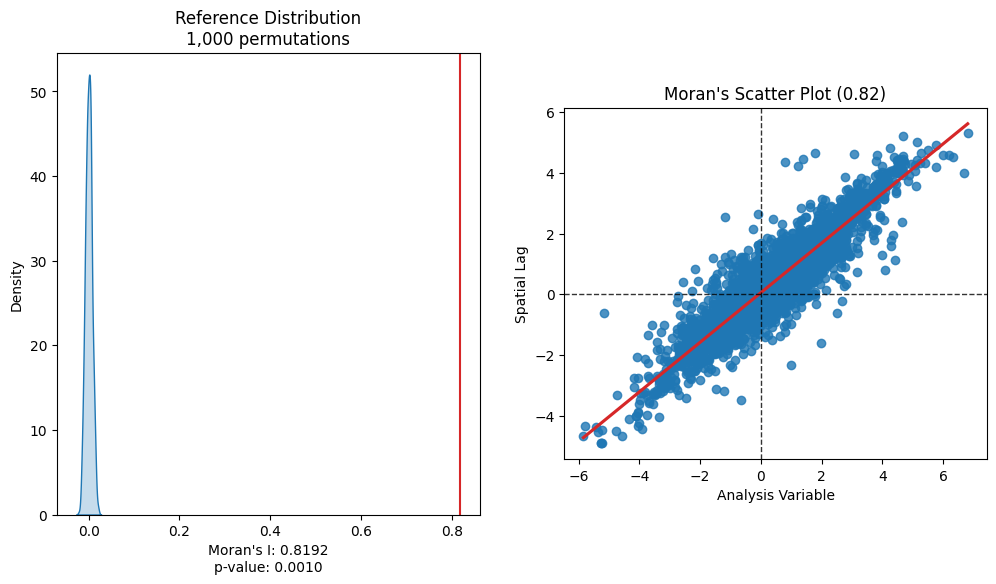

In [22]:
# Moran's I statistic instance
morans_stat = esda.moran.Moran(
    y=residual_test.residuals
    ,w=W
    ,transformation='R'
    ,permutations=1_000)

# Figure specs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Visualization elements
sns.kdeplot(
    data=morans_stat.sim
    ,fill=True
    ,ax=ax[0])
ax[0].axvline(x=morans_stat.I, color='tab:red')
sns.regplot(
    data=residual_test
    ,x='residuals'
    ,y='residuals_spatial_lag'
    ,ci=None
    ,line_kws=dict(color='tab:red')
    ,ax=ax[1])
ax[1].axvline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')
ax[1].axhline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')


# Styling
ax[0].set(
    title=f'Reference Distribution\n{morans_stat.permutations:,} permutations'
    ,xlabel=f"Moran's I: {morans_stat.I:.4f}\np-value: {morans_stat.p_sim:.4f}"
    ,ylabel='Density')
ax[1].set(
    title=f"Moran's Scatter Plot ({morans_stat.I:.2f})"
    ,xlabel='Analysis Variable'
    ,ylabel='Spatial Lag')
ax[1].set_aspect('equal')

plt.show()

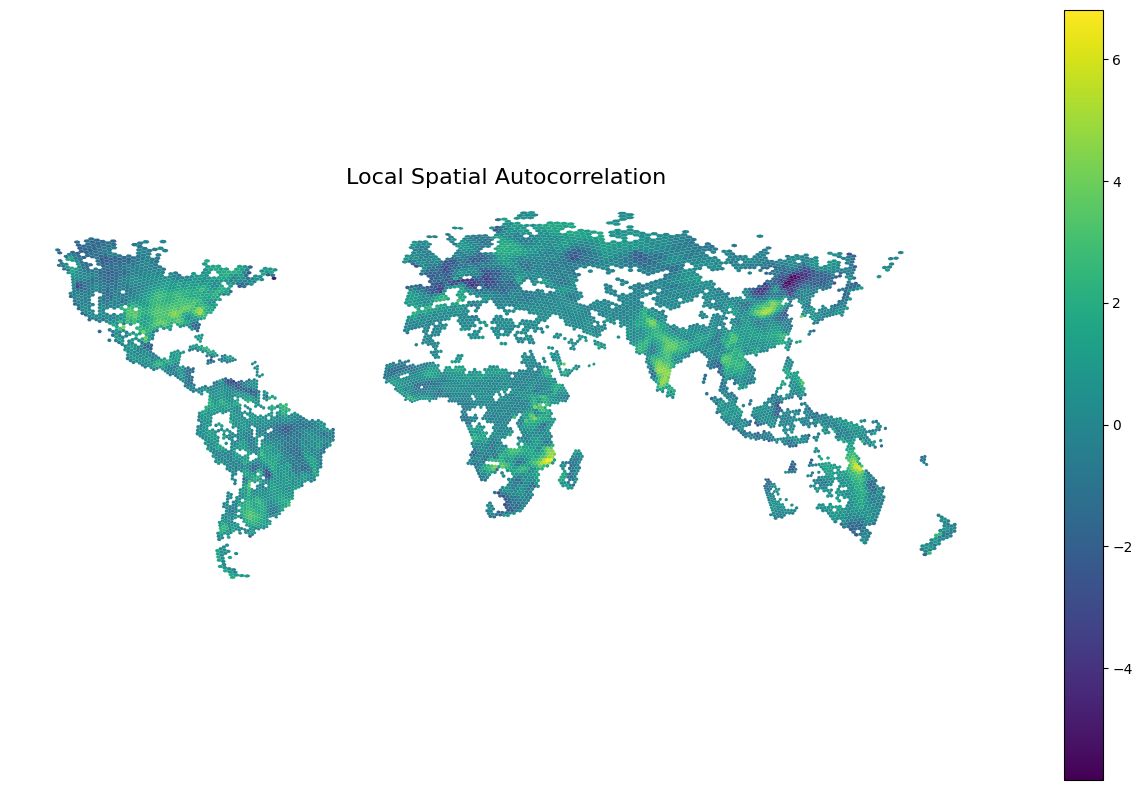

In [23]:
# Figure specs
fig, ax = plt.subplots(figsize=(16,10))

# Visualization elements
residual_test.plot(
    column='residuals'
    ,legend=True
    ,ax=ax)

# Styling
ax.set_title(
    label='Local Spatial Autocorrelation'
    ,fontsize=16)
ax.set_yticks([])
ax.set_xticks([])
ax.set_frame_on(False)

plt.show()

# Modelo con regularización Elastic Net

Primero se define una instancia de _GridSearch_ para la optimización de modelo Elastic Net

In [ ]:
%%time

# Espacio parametral
grid = {
    'alpha': np.logspace(start=-2, stop=2, num=25),
    'l1_ratio': np.arange(start=0, stop=1.1, step=0.1)}

# Instancia de modelo a optimizar
elastic_net = ElasticNet(
    fit_intercept=True,)

# Iniciar objeto de optimización
gsearch = GridSearchCV(
    estimator=elastic_net,
    param_grid=grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=4,
    verbose=1,
    return_train_score=True)

# Entrenamiento de modelo
gsearch = gsearch.fit(X=x_train, y=y_train)

# Almacenar resultados
results = gsearch.cv_results_

In [ ]:
gsearch.best_estimator_

# Modelo con regularización Ridge

## TODO: Probar alphas grandes

Dado que el modelo con regularización ElasticNet recuperó el caso Ridge, se continúa la optimización del modelo considerando sólo regularización con norma L2

In [24]:
%%time

# Espacio parametral
# x_train dtype: float16
# np.logspace(start=-6, stop=1, num=8):             best -> 0.001
# np.logspace(start=-4, stop=-2, num=10):           best -> 0.00215443
# np.linspace(start=0.0012, stop=0.0034, num=12):   best -> 0.0026
# x_train dtype: float32
# np.linspace(start=0.0022, stop=0.003, num=10):    best -> 0.00255
# x_train dtype: float64                             overflow

grid = {
    'alpha': np.linspace(start=0.0022, stop=0.003, num=10)}

# Instancia de modelo a optimizar
ridge = Ridge(
    fit_intercept=True,)

# Iniciar objeto de optimización
gsearch = GridSearchCV(
    estimator=ridge,
    param_grid=grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=4,
    verbose=1,
    return_train_score=True)

# Entrenamiento de modelo
gsearch = gsearch.fit(X=x_train, y=y_train)

# Almacenar resultados
results = gsearch.cv_results_

Fitting 4 folds for each of 10 candidates, totalling 40 fits
CPU times: total: 48.9 s
Wall time: 3min 4s


c:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.92992e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [25]:
gsearch.best_estimator_

Ridge(alpha=0.0025555555555555557)

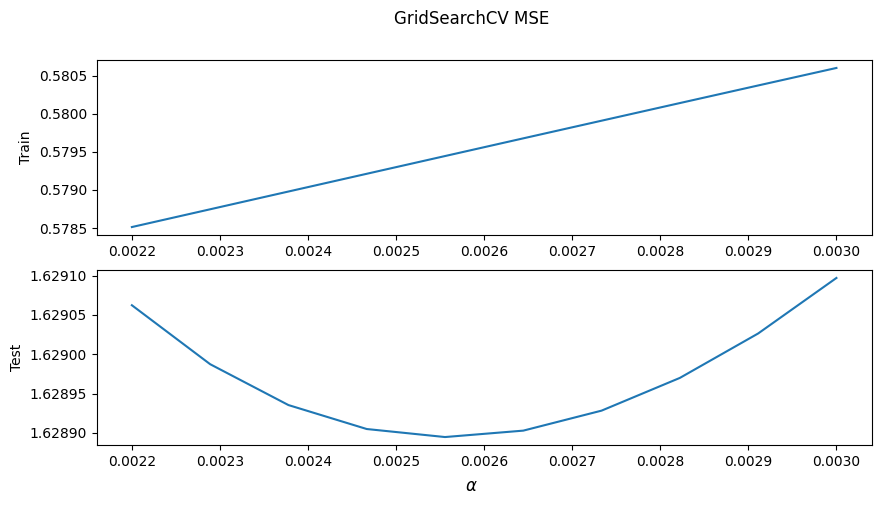

In [32]:
# Especificaciones de figura
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,5))

# Elementos de visualización
ax[0].plot(
    np.linspace(start=0.0022, stop=0.003, num=10),
    -gsearch.cv_results_['mean_train_score'])
ax[1].plot(
    np.linspace(start=0.0022, stop=0.003, num=10),
    -gsearch.cv_results_['mean_test_score'])

# Anotaciones y estilo
ax[0].set_ylabel('Train')
ax[1].set_ylabel('Test')
fig.suptitle('GridSearchCV MSE')
fig.supxlabel(r'$\alpha$')

plt.show()

Validación cruzada con el mejor estimador

In [33]:
cross_val = cross_validate(
    estimator=gsearch.best_estimator_,
    X=x_train,
    y=y_train,
    scoring=['r2', 'neg_mean_squared_error'],
    cv=6)

cross_val

c:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.8548e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.72495e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.74061e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.84256e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite

{'fit_time': array([5.52066994, 5.90153313, 5.92858887, 5.58805943, 5.59281445,
        5.5398488 ]),
 'score_time': array([0.07056642, 0.0543468 , 0.04650927, 0.05010796, 0.04685259,
        0.05215693]),
 'test_r2': array([0.78048012, 0.89062005, 0.86592998, 0.88351012, 0.8102479 ,
        0.89397066]),
 'test_neg_mean_squared_error': array([-2.3854037 , -1.43295777, -1.35641215, -1.48797513, -1.60044921,
        -1.39427711])}

In [34]:
rmse = np.sqrt(-cross_val['test_neg_mean_squared_error'])
r2 = cross_val['test_r2']

print(f"Media cross_validate R2:\t{r2.mean():,.2f}")
print(f"Media cross_validate RMSE:\t{rmse.mean():,.2f}")

Media cross_validate R2:	0.85
Media cross_validate RMSE:	1.26


## Desempeño en conjunto de Prueba

In [35]:
y_pred = gsearch.best_estimator_.predict(X=x_test)

In [36]:
var_score_val = explained_variance_score(y_true=y_test, y_pred=y_pred)
r2_val = r2_score(y_true=y_test, y_pred=y_pred)
rmse_val = mean_squared_error(y_true=y_test, y_pred=y_pred)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_val:.2f} %
    coef. determinación: {r2_val:.6f}
    RMSE: {np.sqrt(rmse_val):.6f}""")

Métricas en train:
    varianza explicada: 87.87 %
    coef. determinación: 0.872757
    RMSE: 1.255843


## Normalidad geoespacial de residuales

### Datos expandidos

In [37]:
out_path = os.path.join(
    '..','data',
    'models_output',
    '01_ridge_regression.csv')

In [38]:
residual_test = (
    data
    .query("year == 2019")
    .assign(
        mean_yield_pred = y_pred,
        residuals = lambda df: df.mean_yield_pred - df.mean_yield))

residual_test.to_csv(out_path, index=False)

Carga de datos expandidos leyendo el archivo de salida del modelo

In [39]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)
residual_test.head()

,year,hex_3,mean_precip,mean_temp,mean_yield,mean_yield_pred,residuals
0,2019,830830fffffffff,136.512866,7.503748,5.291118,8.184175,2.893057
1,2019,830833fffffffff,112.218055,7.974006,4.755333,5.444515,0.689182
2,2019,830880fffffffff,55.103881,7.570549,5.866617,5.005693,-0.860923
3,2019,830882fffffffff,44.416754,8.394179,5.053000,4.397492,-0.655508
4,2019,830883fffffffff,65.744323,9.267750,4.921000,5.581562,0.660562


In [40]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)

# Definir columna de geometría
geometry = gpd.GeoSeries(
    data=residual_test[h3_res].apply(func=get_h3_polygon))

# Conversión a GeoPandas
residual_test = gpd.GeoDataFrame(data=residual_test, geometry=geometry)

# Asignar CRS
residual_test.crs = 'EPSG:4326'

residual_test.head()

,year,hex_3,mean_precip,mean_temp,mean_yield,mean_yield_pred,residuals,geometry
0,2019,830830fffffffff,136.512866,7.503748,5.291118,8.184175,2.893057,"POLYGON ((6.79130 63.96438, 5.86142 63.76021, ..."
1,2019,830833fffffffff,112.218055,7.974006,4.755333,5.444515,0.689182,"POLYGON ((8.72210 63.84278, 7.79997 63.65181, ..."
2,2019,830880fffffffff,55.103881,7.570549,5.866617,5.005693,-0.860923,"POLYGON ((17.25045 60.41134, 17.26259 59.92157..."
3,2019,830882fffffffff,44.416754,8.394179,5.053000,4.397492,-0.655508,"POLYGON ((18.26105 59.69862, 18.26353 59.20079..."
4,2019,830883fffffffff,65.744323,9.267750,4.921000,5.581562,0.660562,"POLYGON ((19.26639 60.45218, 19.25929 59.96206..."


### Rezago espacial

Primero se define la matriz de pesos utilizando el criterio de contigüidad kNN dado que son puntos de coordenadas

In [41]:
# Matriz de pesos espaciales
W = Queen.from_dataframe(
    df=residual_test,
    geom_col='geometry',
    silence_warnings=True)

# Estandarizar por renglón los pesos
W.set_transform(value='R')

Ahora se calcula el rezago espacial con respecto a la variable objetivo

In [42]:
residual_test['residuals_spatial_lag'] = lag_spatial(
    w=W,
    y=residual_test.residuals)

Finalmente, se visualiza la dispersión de Moran

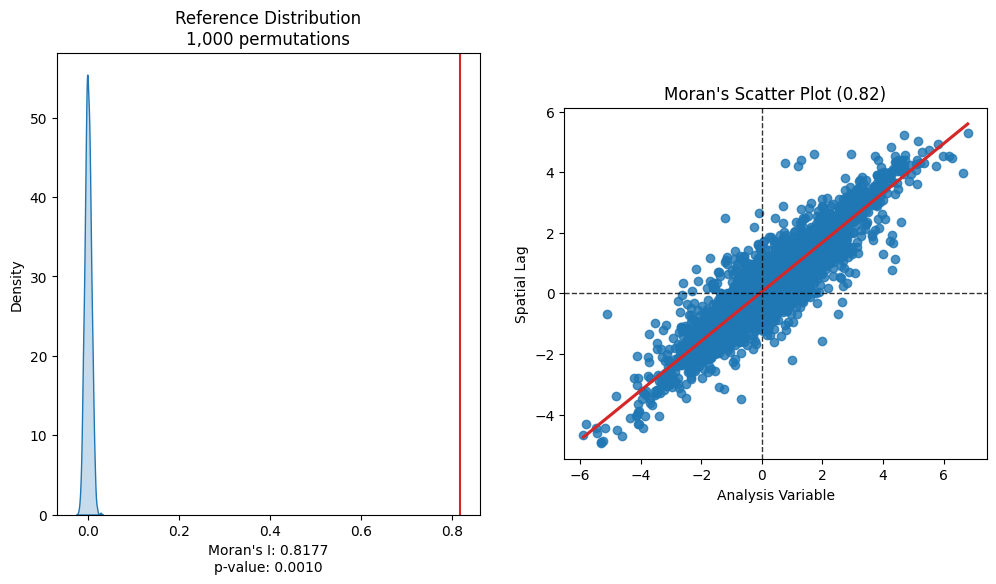

In [43]:
# Moran's I statistic instance
morans_stat = esda.moran.Moran(
    y=residual_test.residuals
    ,w=W
    ,transformation='R'
    ,permutations=1_000)

# Figure specs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Visualization elements
sns.kdeplot(
    data=morans_stat.sim
    ,fill=True
    ,ax=ax[0])
ax[0].axvline(x=morans_stat.I, color='tab:red')
sns.regplot(
    data=residual_test
    ,x='residuals'
    ,y='residuals_spatial_lag'
    ,ci=None
    ,line_kws=dict(color='tab:red')
    ,ax=ax[1])
ax[1].axvline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')
ax[1].axhline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')


# Styling
ax[0].set(
    title=f'Reference Distribution\n{morans_stat.permutations:,} permutations'
    ,xlabel=f"Moran's I: {morans_stat.I:.4f}\np-value: {morans_stat.p_sim:.4f}"
    ,ylabel='Density')
ax[1].set(
    title=f"Moran's Scatter Plot ({morans_stat.I:.2f})"
    ,xlabel='Analysis Variable'
    ,ylabel='Spatial Lag')
ax[1].set_aspect('equal')

plt.show()

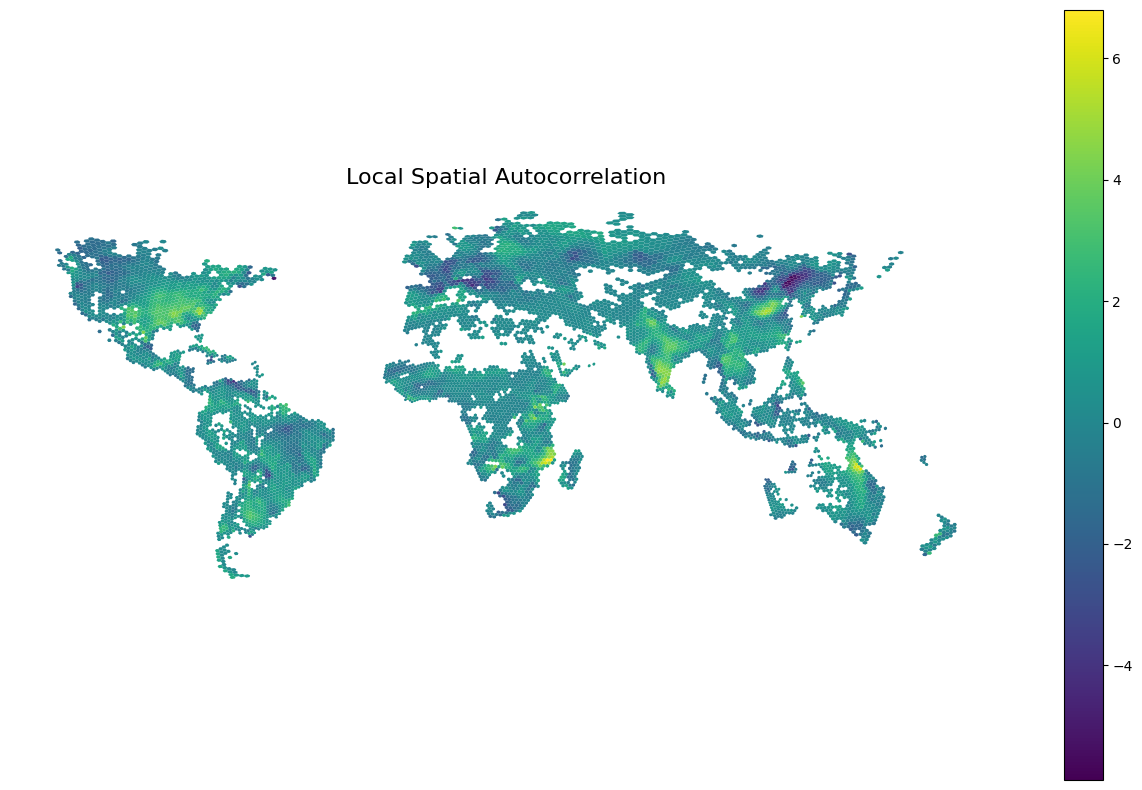

In [44]:
# Figure specs
fig, ax = plt.subplots(figsize=(16,10))

# Visualization elements
residual_test.plot(
    column='residuals'
    ,legend=True
    ,ax=ax)

# Styling
ax.set_title(
    label='Local Spatial Autocorrelation'
    ,fontsize=16)
ax.set_yticks([])
ax.set_xticks([])
ax.set_frame_on(False)

plt.show()

# Modelo con regularización Lasso

In [8]:
%%time

# Espacio parametral
# x_train dtype: float16
# np.logspace(start=-6, stop=6, num=13)             best -> 1e-6

grid = {
    'alpha': np.logspace(start=-6, stop=6, num=13)}

# Instancia de modelo a optimizar
lasso = Lasso(
    fit_intercept=True,)

# Iniciar objeto de optimización
gsearch = GridSearchCV(
    estimator=lasso,
    param_grid=grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=4,
    verbose=1,
    return_train_score=True)

# Entrenamiento de modelo
gsearch = gsearch.fit(X=x_train, y=y_train)

# Almacenar resultados
results = gsearch.cv_results_

Fitting 4 folds for each of 13 candidates, totalling 52 fits
CPU times: total: 5min 47s
Wall time: 1h 14min 48s


c:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.100e+03, tolerance: 3.313e+01
  model = cd_fast.enet_coordinate_descent(


In [9]:
gsearch.best_estimator_

Lasso(alpha=1e-06)

Validación cruzada con el mejor estimador

In [36]:
lasso = Lasso(
    alpha=10_000,
    fit_intercept=True,)

cross_val = cross_validate(
    estimator=lasso,
    X=x_train,
    y=y_train,
    scoring=['r2', 'neg_mean_squared_error'],
    cv=6,
    n_jobs=-1)

cross_val

{'fit_time': array([11.70479679, 11.7187736 , 12.12711716, 11.92515206, 10.1750505 ,
        11.61064529]),
 'score_time': array([0.25335264, 0.25077057, 0.14697146, 0.18631959, 0.36787415,
        0.25974464]),
 'test_r2': array([-0.24441938, -0.24112369, -0.29268391, -0.23428755, -0.38045609,
        -0.20318929]),
 'test_neg_mean_squared_error': array([-13.52243188, -16.25963308, -13.0783314 , -15.7660831 ,
        -11.64334862, -15.82183979])}

In [37]:
rmse = np.sqrt(-cross_val['test_neg_mean_squared_error'])
r2 = cross_val['test_r2']

print(f"Media cross_validate R2:\t{r2.mean():,.2f}")
print(f"Media cross_validate RMSE:\t{rmse.mean():,.2f}")

Media cross_validate R2:	-0.27
Media cross_validate RMSE:	3.78


## Desempeño en conjunto de Prueba

In [38]:
lasso = lasso.fit(X=x_train, y=y_train)
y_pred = lasso.predict(X=x_test)

In [39]:
var_score_val = explained_variance_score(y_true=y_test, y_pred=y_pred)
r2_val = r2_score(y_true=y_test, y_pred=y_pred)
rmse_val = mean_squared_error(y_true=y_test, y_pred=y_pred)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_val:.2f} %
    coef. determinación: {r2_val:.6f}
    RMSE: {np.sqrt(rmse_val):.6f}""")

Métricas en train:
    varianza explicada: 0.00 %
    coef. determinación: -0.005958
    RMSE: 3.531090


## Normalidad geoespacial de residuales

### Datos expandidos

In [40]:
out_path = os.path.join(
    '..','data',
    'models_output',
    '02_lasso_regression.csv')

In [41]:
residual_test = (
    data
    .query("year == 2019")
    .assign(
        mean_yield_pred = y_pred,
        residuals = lambda df: df.mean_yield_pred - df.mean_yield))

residual_test.to_csv(out_path, index=False)

Carga de datos expandidos leyendo el archivo de salida del modelo

In [42]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)
residual_test.head()

,year,hex_3,mean_precip,mean_temp,mean_yield,mean_yield_pred,residuals
0,2019,830830fffffffff,136.512866,7.503748,5.291118,5.418687,0.127569
1,2019,830833fffffffff,112.218055,7.974006,4.755333,5.418687,0.663354
2,2019,830880fffffffff,55.103881,7.570549,5.866617,5.418687,-0.447930
3,2019,830882fffffffff,44.416754,8.394179,5.053000,5.418687,0.365687
4,2019,830883fffffffff,65.744323,9.267750,4.921000,5.418687,0.497687


In [43]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)

# Definir columna de geometría
geometry = gpd.GeoSeries(
    data=residual_test[h3_res].apply(func=get_h3_polygon))

# Conversión a GeoPandas
residual_test = gpd.GeoDataFrame(data=residual_test, geometry=geometry)

# Asignar CRS
residual_test.crs = 'EPSG:4326'

residual_test.head()

,year,hex_3,mean_precip,mean_temp,mean_yield,mean_yield_pred,residuals,geometry
0,2019,830830fffffffff,136.512866,7.503748,5.291118,5.418687,0.127569,"POLYGON ((6.79130 63.96438, 5.86142 63.76021, ..."
1,2019,830833fffffffff,112.218055,7.974006,4.755333,5.418687,0.663354,"POLYGON ((8.72210 63.84278, 7.79997 63.65181, ..."
2,2019,830880fffffffff,55.103881,7.570549,5.866617,5.418687,-0.447930,"POLYGON ((17.25045 60.41134, 17.26259 59.92157..."
3,2019,830882fffffffff,44.416754,8.394179,5.053000,5.418687,0.365687,"POLYGON ((18.26105 59.69862, 18.26353 59.20079..."
4,2019,830883fffffffff,65.744323,9.267750,4.921000,5.418687,0.497687,"POLYGON ((19.26639 60.45218, 19.25929 59.96206..."


### Rezago espacial

Primero se define la matriz de pesos utilizando el criterio de contigüidad kNN dado que son puntos de coordenadas

In [44]:
# Matriz de pesos espaciales
W = Queen.from_dataframe(
    df=residual_test,
    geom_col='geometry',
    silence_warnings=True)

# Estandarizar por renglón los pesos
W.set_transform(value='R')

Ahora se calcula el rezago espacial con respecto a la variable objetivo

In [45]:
residual_test['residuals_spatial_lag'] = lag_spatial(
    w=W,
    y=residual_test.residuals)

Finalmente, se visualiza la dispersión de Moran

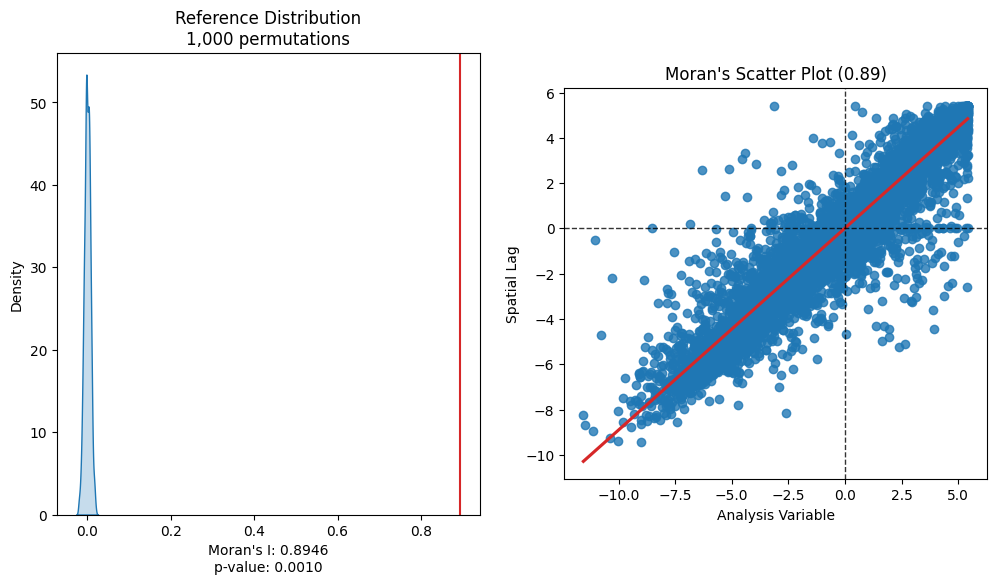

In [46]:
# Moran's I statistic instance
morans_stat = esda.moran.Moran(
    y=residual_test.residuals
    ,w=W
    ,transformation='R'
    ,permutations=1_000)

# Figure specs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Visualization elements
sns.kdeplot(
    data=morans_stat.sim
    ,fill=True
    ,ax=ax[0])
ax[0].axvline(x=morans_stat.I, color='tab:red')
sns.regplot(
    data=residual_test
    ,x='residuals'
    ,y='residuals_spatial_lag'
    ,ci=None
    ,line_kws=dict(color='tab:red')
    ,ax=ax[1])
ax[1].axvline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')
ax[1].axhline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')


# Styling
ax[0].set(
    title=f'Reference Distribution\n{morans_stat.permutations:,} permutations'
    ,xlabel=f"Moran's I: {morans_stat.I:.4f}\np-value: {morans_stat.p_sim:.4f}"
    ,ylabel='Density')
ax[1].set(
    title=f"Moran's Scatter Plot ({morans_stat.I:.2f})"
    ,xlabel='Analysis Variable'
    ,ylabel='Spatial Lag')
ax[1].set_aspect('equal')

plt.show()

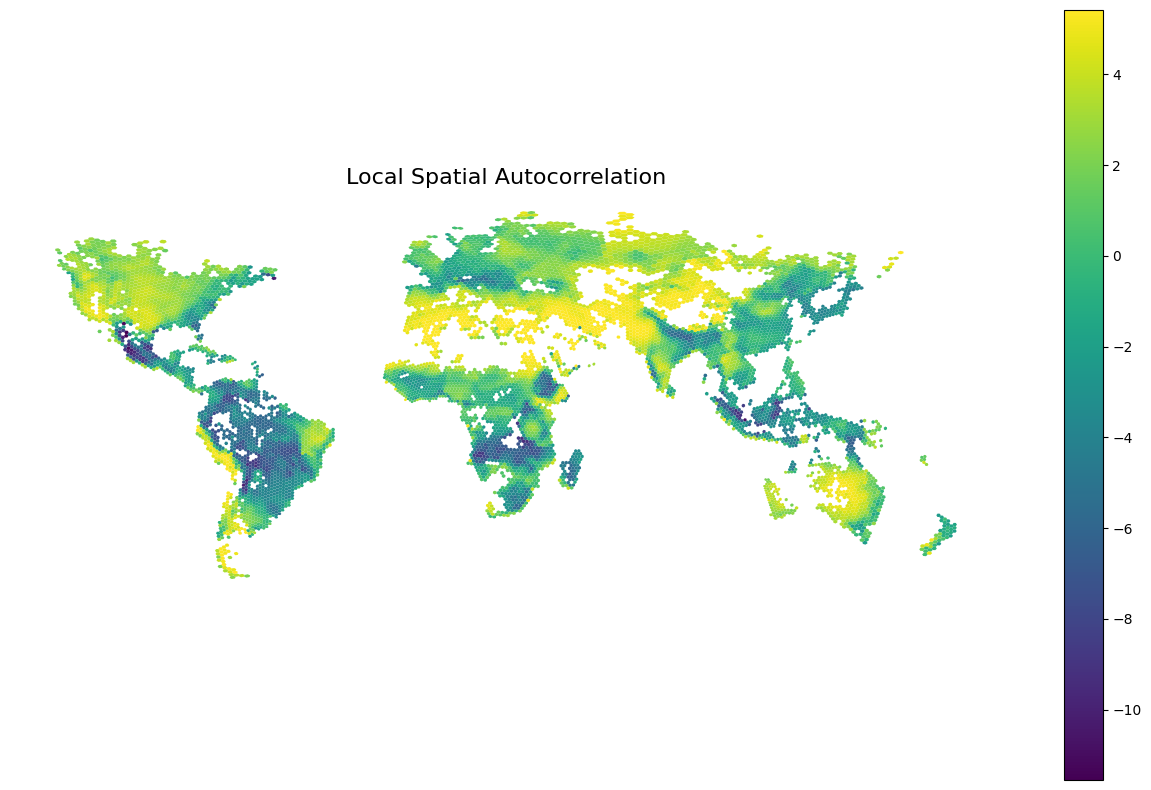

In [47]:
# Figure specs
fig, ax = plt.subplots(figsize=(16,10))

# Visualization elements
residual_test.plot(
    column='residuals'
    ,legend=True
    ,ax=ax)

# Styling
ax.set_title(
    label='Local Spatial Autocorrelation'
    ,fontsize=16)
ax.set_yticks([])
ax.set_xticks([])
ax.set_frame_on(False)

plt.show()